In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 5)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2, 3, 4]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 300
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-11-28 16:20:20.890499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:20:20.912424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 16:20:20.941674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 16:20:20.949486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:20:20.970158: I tensorflow/core/platform/cpu_feature_guar

Training set size: 240
Test set size: 60
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(240, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_sampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 52, 1: 68, 2: 57, 3: 66, 4: 57}


In [11]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_multi_5.pth"

In [13]:
# Create an instance of the new model with attention extraction
model = QSANN_text_classifier(64, 4, 2, 1, 1)
model.load_state_dict(torch.load(model_save_path))
model.eval()

/tmp/ipykernel_209398/3952207360.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


QSANN_text_classifier(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=5, bias=True)
)

In [14]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([5, 1024])
Number of parameters: 5120
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([5])
Number of parameters: 5
--------------------------------------------------
Total number of trainable parameters: 7429


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 64, 16])
Row sums: [58.51123  48.789215 57.46512  57.83097  54.88942  39.065716 55.532433
 53.287117 57.912632 52.512413 56.8211   56.089226 50.097775 44.37992
 45.235603 56.31977  57.969013 50.795624 55.832977 48.445454 54.341347
 57.866596 45.440094 58.24797  57.237633 58.233505 53.574677 58.364475
 47.47982  55.421425 48.64569  57.54055  55.029182 56.47185  52.9482
 55.993954 48.583946 57.16655  50.04401  58.549164 56.168365 55.918575
 54.00091  58.10383  57.083298 54.89934  53.69136  57.528168 53.408684
 56.571564 56.692047 56.182632 57.68451  52.715416 55.56295  51.18406
 55.64738  53.366943 56.477524 58.336388 56.93592  49.696213 48.31027
 55.2686  ]


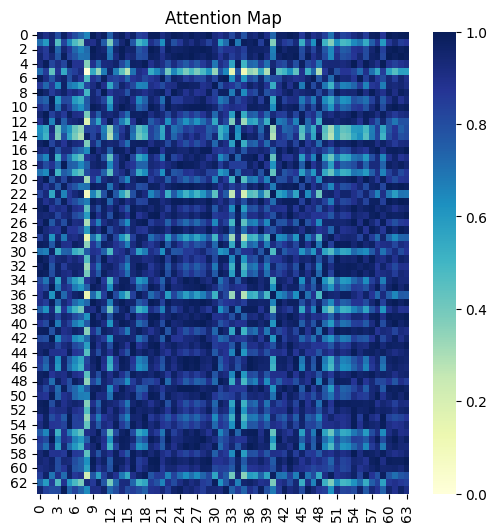

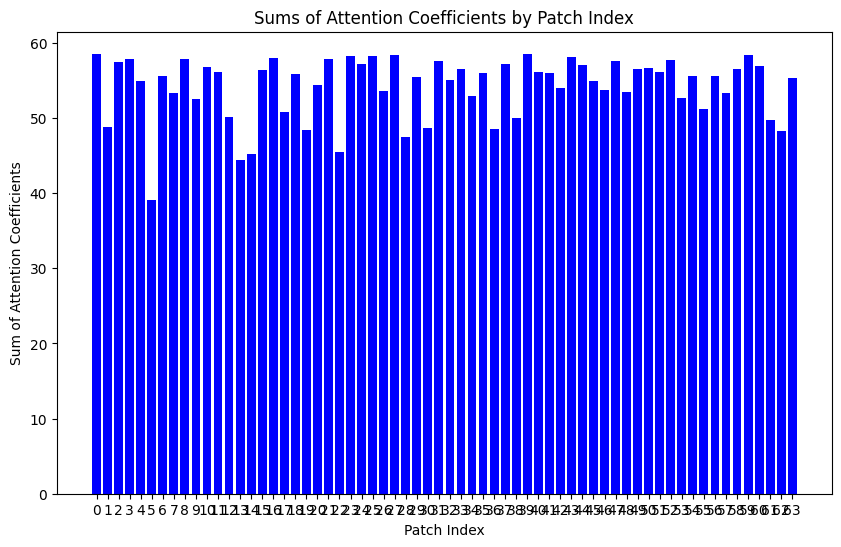

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1               [-1, 64, 16]               0
   QSANN_pennylane-2               [-1, 64, 16]               0
            Linear-3                    [-1, 5]           5,125
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [15]:
from torchsummary import summary
summary(model, input_size=(64, 16))  # (sequence_length, embed_size)


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 64, 16])
Row sums: [54.17693  52.366478 49.469963 50.770317 49.195877 46.395588 58.45797
 49.60182  46.782227 56.568924 56.63901  57.668808 51.862137 57.353188
 53.350338 58.345963 52.6145   52.56636  56.068203 50.783115 40.91706
 58.73954  51.801666 58.606598 57.911407 54.330673 55.185246 51.343987
 48.3582   56.824024 50.7025   56.54313  58.529068 57.29167  43.72989
 57.027275 55.1073   55.3303   49.52505  58.560596 57.710274 51.232277
 50.135323 52.84075  56.28927  55.625237 57.73675  50.028275 44.094315
 58.25419  58.174194 58.162724 58.295044 58.513702 58.337067 41.00151
 50.487793 52.998306 54.226933 58.442272 57.1902   56.77634  45.981705
 54.14867 ]


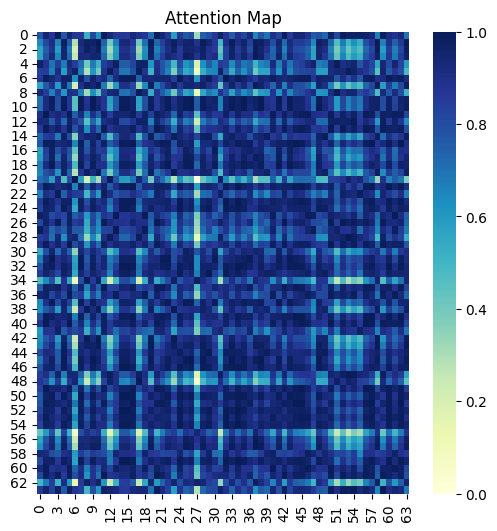

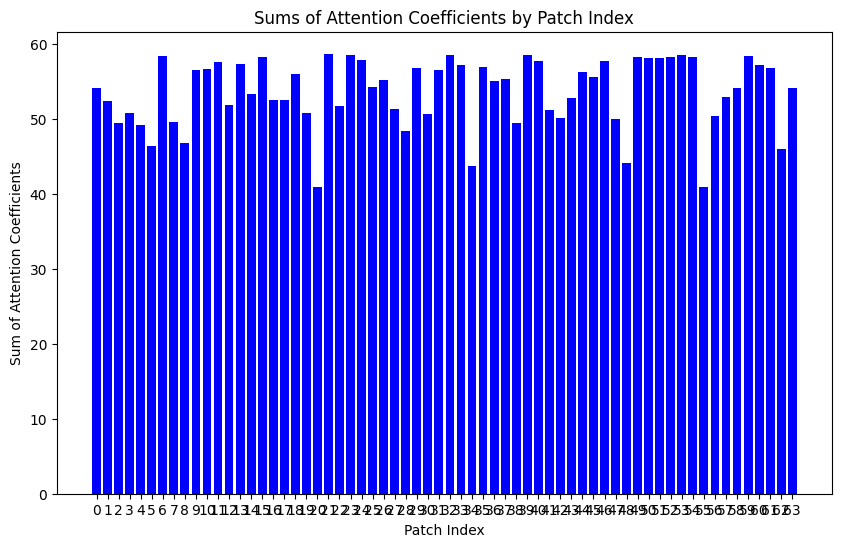

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1               [-1, 64, 16]               0
   QSANN_pennylane-2               [-1, 64, 16]               0
            Linear-3                    [-1, 5]           5,125
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [15]:
from torchsummary import summary
summary(model, input_size=(64, 16))  # (sequence_length, embed_size)


In [18]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [19]:
# for iepoch in tqdm(range(50)):
#     optimizer.zero_grad()
#     X_tensor=torch.tensor(X_train)
#     predictions=model(X_tensor.float()).squeeze(1)
#     #predictions=torch.sign(predictions)
#     #print(predictions)
#     label=torch.tensor(y_train)
#     #for i in range(len(label)):
#     #    if label[i]==1:
#     #        label[i] = 0
#     #    else:
#     #        label[i]=1
#     #print(label)
#     loss = criterion(predictions, label.float())
#     acc = multi_accuracy(predictions, label)
#     print('')
#     print('Accuracy:',acc)
#     print('')
#     print(loss)
#     loss.backward()
#     optimizer.step()
#     # Save the model parameters
#     torch.save(model.state_dict(), model_save_path)
#     print("Model parameters saved (epoch).")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

torch.Size([60, 64, 16])
Row sums: [55.37893  49.421013 48.562263 56.48181  46.99041  46.788826 56.498535
 48.17296  52.69123  55.84861  52.9065   52.569016 33.662964 48.30232
 53.218132 55.082825 55.06118  54.36924  52.298435 47.70634  50.90538
 55.92169  48.350304 56.225845 57.082787 56.16062  50.58528  53.963303
 34.86624  51.595665 46.44039  55.891693 54.991234 54.740025 52.023064
 56.60011  50.897606 54.219273 52.892216 56.952087 56.421844 53.04103
 52.162067 54.142395 54.116867 37.61361  47.02227  53.074562 49.74169
 55.455116 54.84425  48.970528 50.230614 55.560112 57.099167 49.73866
 35.387764 54.158066 57.276806 55.637787 56.492687 46.087597 43.419586
 54.034054]


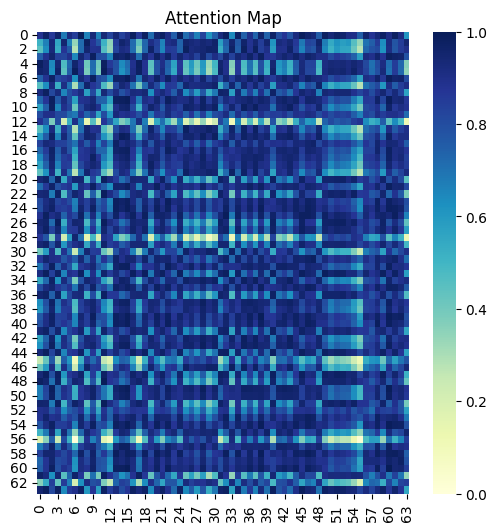

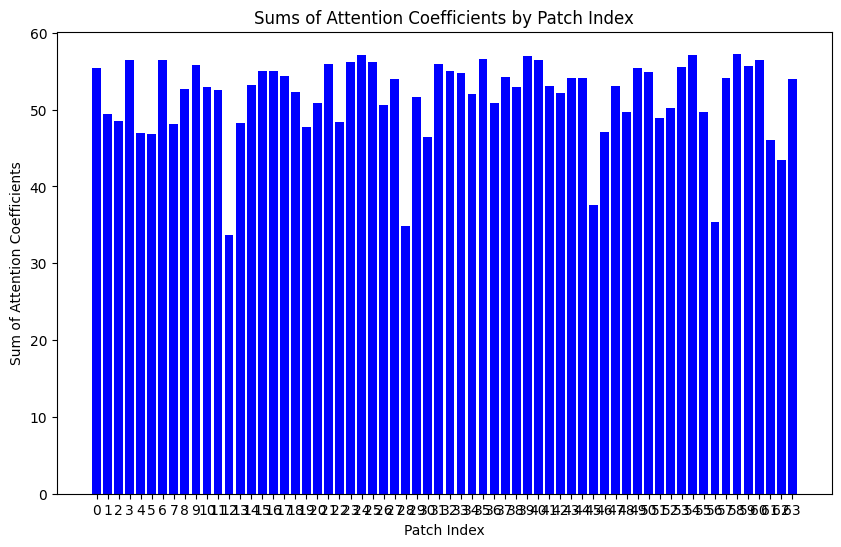

tensor([0, 1, 0, 2, 0, 1, 0, 2, 0, 3, 0, 0, 2, 0, 2, 0, 0, 3, 3, 3, 3, 1, 2, 1,
        3, 3, 3, 2, 1, 0, 2, 0, 3, 1, 0, 0, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 3, 0,
        1, 2, 2, 3, 0, 3, 0, 0, 3, 1, 0, 3])
tensor([2., 0., 0., 0., 1., 0., 2., 1., 4., 0., 3., 2., 2., 4., 4., 4., 3., 2.,
        3., 4., 2., 1., 2., 1., 3., 1., 1., 4., 1., 3., 0., 4., 3., 1., 1., 3.,
        1., 4., 2., 3., 1., 4., 3., 2., 1., 0., 3., 0., 4., 1., 2., 3., 2., 1.,
        3., 4., 4., 0., 0., 3.], dtype=torch.float64)

Accuracy: 0.36666667461395264

AUROC: 0.6244703970870913

Precision (macro): 0.3188516746411483

Recall (macro): 0.3586013986013986

F1 Score (macro): 0.3303023872679045

AUPRC (macro): 0.39474378158415446



/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)

loss = criterion(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_1.pth"

In [28]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [29]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

In [30]:
# # Training the model
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor = torch.tensor(X_train)
#     predictions = model(X_tensor.float()).squeeze(1)
    
#     label = torch.tensor(y_train)
#     for i in range(len(label)):
#         label[i] = 0 if label[i] == 1 else 1
    
#     loss = criterion(predictions, label.float())
#     acc = binary_accuracy(predictions, label)
#     print(f'Accuracy: {acc}')
#     print(f'Loss: {loss}')
    
#     loss.backward()
#     optimizer.step()
#     print(f"Complete {iepoch} th")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

Row sums: [54.11699  56.878517 43.35569  56.913185 55.968674 35.168243 54.307762
 48.510445 55.78875  51.240906 52.733814 49.403328 57.427116 51.244587
 57.29963  54.930862 51.178837 52.273533 53.392807 55.21904  49.06929
 53.656677 56.861076 53.735203 36.109394 57.28287  54.76024  54.20981
 56.906754 47.749794 55.34877  53.009857 55.21425  53.614975 55.701614
 54.482384 41.28666  51.640495 37.764496 55.664036 56.97918  57.06447
 51.871452 54.688656 44.649097 54.94396  55.760544 57.082935 57.028877
 50.91393  54.085045 55.48645  56.92231  55.1949   57.25741  56.991203
 46.40087  52.99317  55.702488 55.967457 48.267536 49.696747 31.638039
 53.93479 ]


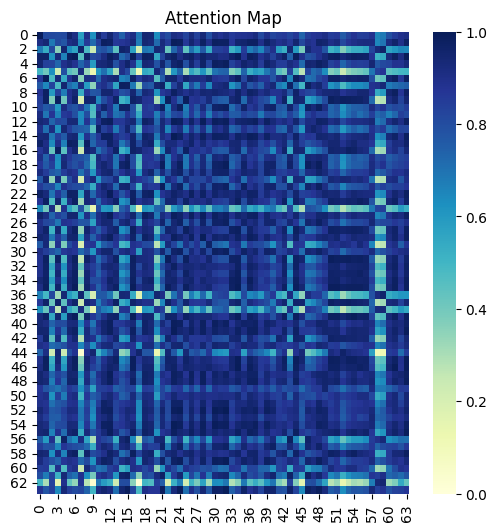

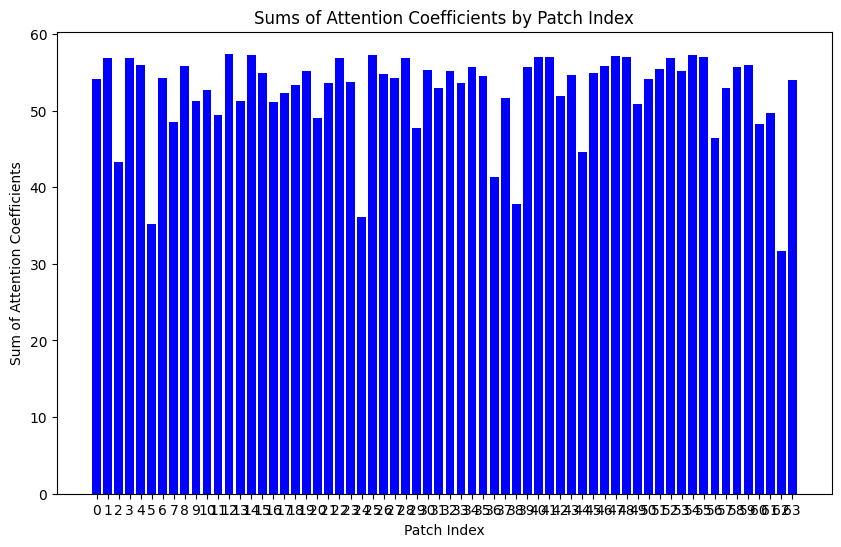


Accuracy: 0.8999999761581421

Loss: 68.84530639648438

AUROC: 0.9625

Precision: 0.9

Recall: 0.9

F1 Score: 0.9

AUPRC: 0.9554093648962576



/tmp/ipykernel_308884/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [31]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


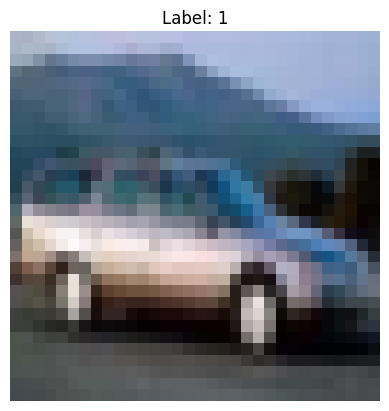

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[4]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[4][0]}')
plt.axis('off')
plt.show()


In [30]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [31]:
single

array([[[179.062, 177.062, 184.66 , ...,  98.915, 100.083,  93.169],
        [194.023, 192.468, 194.006, ...,  95.287,  95.238,  94.928],
        [193.463, 192.762, 195.039, ...,  91.069,  98.792, 102.526],
        ...,
        [ 57.854,  44.854,  49.082, ...,  91.961,  87.548,  84.124],
        [ 28.869,  28.755,  26.858, ...,  78.124,  78.548,  75.146],
        [ 23.445,  26.146,  28.146, ...,  78.146,  74.146,  76.146]]])

In [32]:
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

In [33]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [34]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


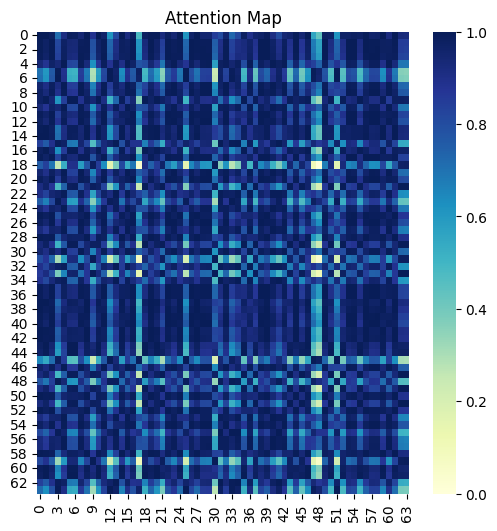

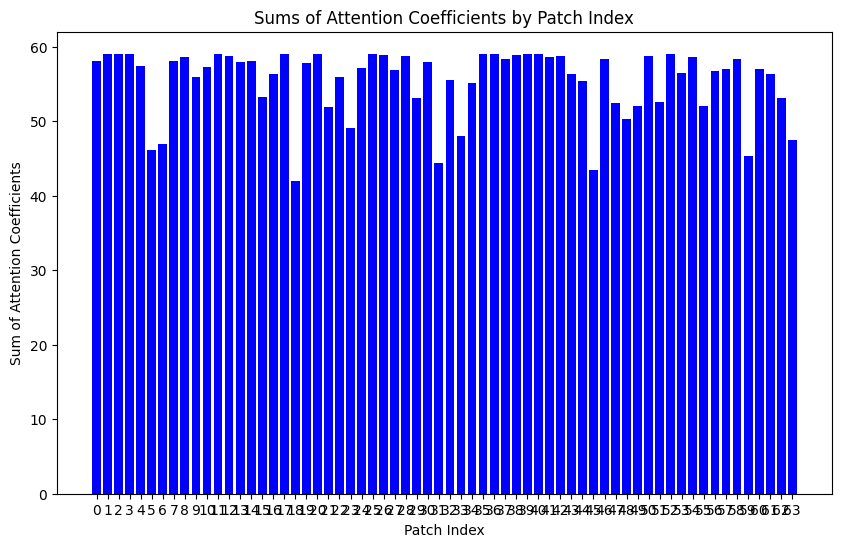

Predicted class for the sample: 1.0
Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


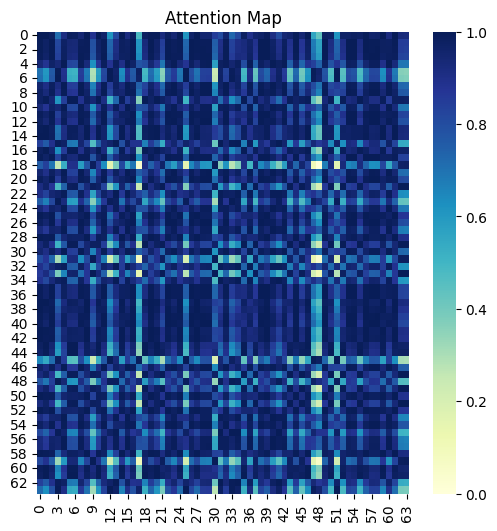

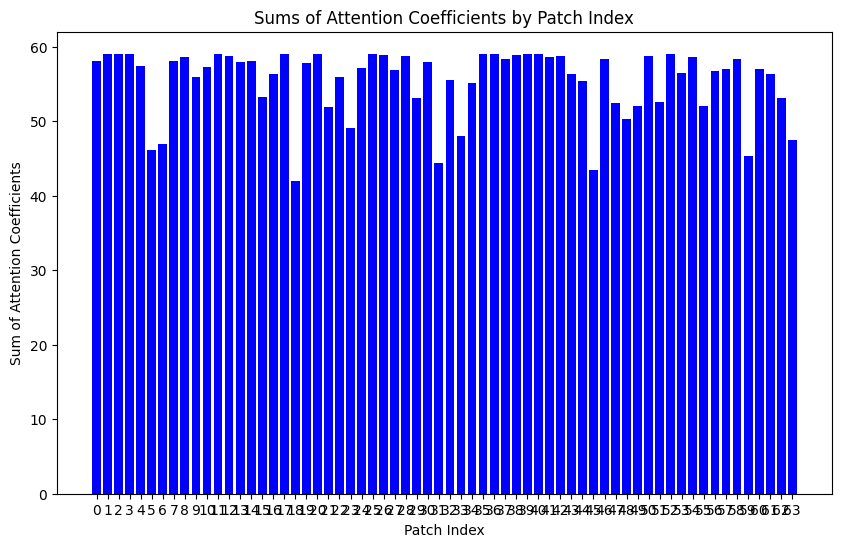

Extracted attention values: tensor([[[0.9977, 0.9988, 0.9877,  ..., 0.9987, 0.9493, 0.9467],
         [0.9968, 0.9808, 1.0000,  ..., 0.9952, 0.8950, 0.8914],
         [0.9960, 0.9791, 1.0000,  ..., 0.9943, 0.8912, 0.8875],
         ...,
         [0.9846, 0.9982, 0.9654,  ..., 0.9875, 0.9773, 0.9755],
         [0.8865, 0.8317, 0.9225,  ..., 0.8786, 0.6781, 0.6730],
         [0.8057, 0.7415, 0.8510,  ..., 0.7962, 0.5775, 0.5724]]])


In [35]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

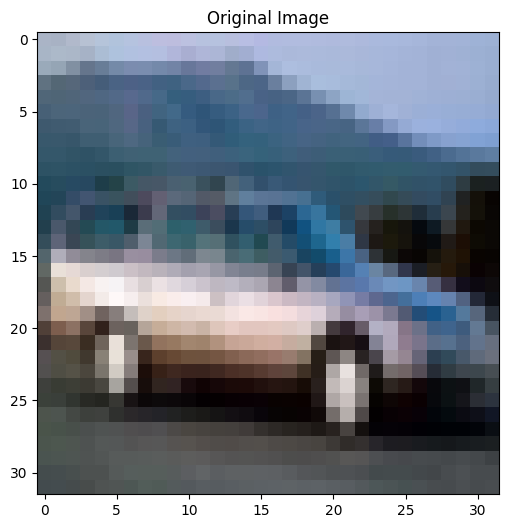

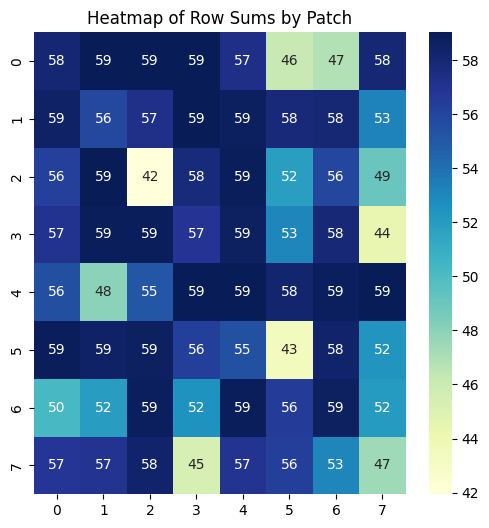

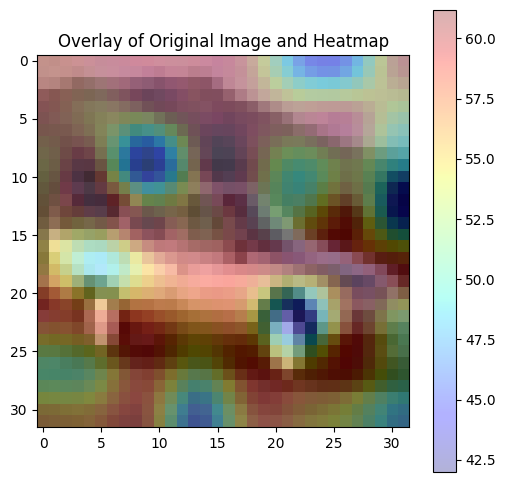

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.3, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[58.063984, 59.032066, 59.03582, 59.017338, 57.32975, 46.169643, 46.861065, 57.99359, 58.530388, 55.853123, 57.24405, 59.015244, 58.757797, 57.89521, 58.031208, 53.21495, 56.294098, 59.03276, 41.93651, 57.794792, 58.947304, 51.86485, 55.909496, 49.107193, 57.081688, 58.942497, 58.872932, 56.888847, 58.687542, 53.02982, 57.938908, 44.345905, 55.55957, 48.011303, 55.104053, 59.01985, 59.016228, 58.261063, 58.81405, 59.035725, 58.967293, 58.558296, 58.699913, 56.319786, 55.409805, 43.420235, 58.356987, 52.373383, 50.236298, 52.02114, 58.777344, 52.491394, 58.941856, 56.457733, 58.637802, 52.067383, 56.77289, 56.96529, 58.363358, 45.35786, 57.029922, 56.30916, 53.03, 47.428307]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


-----------------------------------------